In [8]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mat_image
import sklearn
import pickle
import cv2
from PIL import Image
%matplotlib inline

In [3]:
# Load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
model = pickle.load(open("./model/svm.pickle","rb"))
mean = np.load("./data/pca_50_mean.npz")["arr_1"]
pca = np.load("./data/pca_50_mean.npz",allow_pickle=True)["arr_0"]

pca = pca.tolist()

In [51]:
pickle.dump(open("./model/pca.pickle","wb"),pca)

TypeError: dump() missing required argument 'file' (pos 2)

In [4]:
mean.shape

(10000,)

In [24]:
# color = "bgr"
# test_path = "./data/test.jpg"
# img = cv2.imread(test_path)

def pipeline_model(img,color='rgb'):
    gender = ["male","female"]
    font = cv2.FONT_HERSHEY_SIMPLEX
    if color == "bgr":
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        print("Face Detected")
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
        roi = gray[y:y+h,x:x+w]
        roi = roi/255.0
        if roi.shape[1] > 100:
            print("Resized")
            roi_res = cv2.resize(roi,(100,100),cv2.INTER_LINEAR)
        else:
            roi_res = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
            print("Resized")

        res = roi_res.reshape(1,10000) #1,10k
        roi_mean = res - mean
        eigen_image = pca.transform(roi_mean)
        results = model.predict_proba(eigen_image)[0] #probability
        pred = results.argmax() #0 or 1 index for the maximum probability.
        score = results[pred]
        text = "%s : %0.2f"%(gender[pred],score)
        cv2.putText(img,text,(x,y),font,1,(0,0,255),2) #font scale is  1pixel
        return img

In [7]:
# eig_img = pca.inverse_transform(eigen_image)
# plt.imshow(eig_img.reshape((100,100)),cmap='gray')

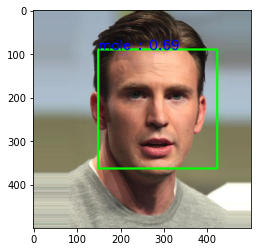

In [11]:
#test data
color = "bgr"
test_path = "./data/test.jpg"

img = Image.open(test_path) # rgb required for deployment
img = np.array(img)
img = pipeline_model(img)
plt.imshow(img)

In [30]:
#Apply to a video

cap = cv2.VideoCapture("./data/video.mp4")
while True:
    ret,frame = cap.read() #bgr
    
    if ret == False:
        break
    try:
        frame = pipeline_model(frame,color = "bgr")
    #     print(frame)
        cv2.imshow("Gender",frame)
    except Exception as e:
        print(e)
        

    if cv2.waitKey(10) == 27: #esc key
        break
        
cv2.destroyAllWindows()
cap.release()